### Imports

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, chi2_contingency, zscore

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA


# Dataset Initialization

In [42]:
# Load the dataset

csv_path = "logs_dataset.csv"

print("Loading the dataset... this may take a minute.")
df = pd.read_csv(csv_path, low_memory=False)

print(f"Dataset loaded successfully! Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

df.head(20)


Loading the dataset... this may take a minute.
Dataset loaded successfully! Shape: 1,000 rows × 8 columns


,timestamp,user_name,parent_process,process,command,command_length,num_args,is_anomaly
0,02-11-25 06:13:08,svc_unknown,winword.exe,msiexec.exe,"powershell -Command ""$wc = New-Object System.N...",129,7,1
1,02-11-25 09:50:21,oleg.kov,winword.exe,msiexec.exe,cmd.exe /c echo hello,21,4,0
2,02-11-25 10:18:14,svc_sql,searchui.exe,schtasks.exe,msiexec /i C:\installers\app.msi /qn,36,4,0
3,02-11-25 11:16:03,li.chen,onedrive.exe,net.exe,whoami,6,1,0
4,02-11-25 11:31:33,svc_sql,msedge.exe,msiexec.exe,Get-Service,11,1,0
5,02-11-25 11:40:03,amir.cohen,explorer.exe,python.exe,Get-ChildItem C:\Users\Public,29,2,0
6,02-11-25 13:28:23,natalie.clark,excel.exe,schtasks.exe,whoami,6,1,0
7,02-11-25 13:46:19,qa.lisa,msedge.exe,net.exe,wscript C:\scripts\cleanup.vbs,30,2,0
8,02-11-25 13:54:09,li.chen,msedge.exe,net.exe,powershell -NoLogo -Command Get-EventLog -LogN...,72,8,0
9,02-11-25 14:15:50,oleg.kov,onedrive.exe,cscript.exe,Get-ChildItem C:\Users\Public,29,2,0


In [43]:
# Columns and their data types

print("Dataset structure overview:\n")
df.info()


Dataset structure overview:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       1000 non-null   object
 1   user_name       1000 non-null   object
 2   parent_process  1000 non-null   object
 3   process         1000 non-null   object
 4   command         1000 non-null   object
 5   command_length  1000 non-null   int64 
 6   num_args        1000 non-null   int64 
 7   is_anomaly      1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


# EDA combined with Preprocessing

## Numeric features exploration

### Distribution of label

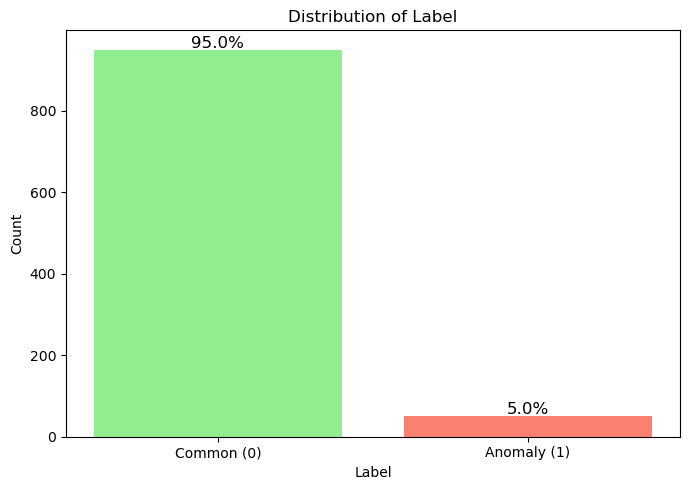

In [44]:

counts = df["is_anomaly"].value_counts().sort_index()

bar_labels = ["Common (0)", "Anomaly (1)"]
colors = ["lightgreen", "salmon"]

plt.figure(figsize=(7, 5))

plt.bar(bar_labels, counts.values, color=colors)

for i, value in enumerate(counts.values):
    plt.text(i, value + 5, str(value/10)+"%", ha='center', fontsize=12)

plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of Label")

plt.tight_layout()
plt.show()


5% of the instances are Anomalous

### Command lengths per label

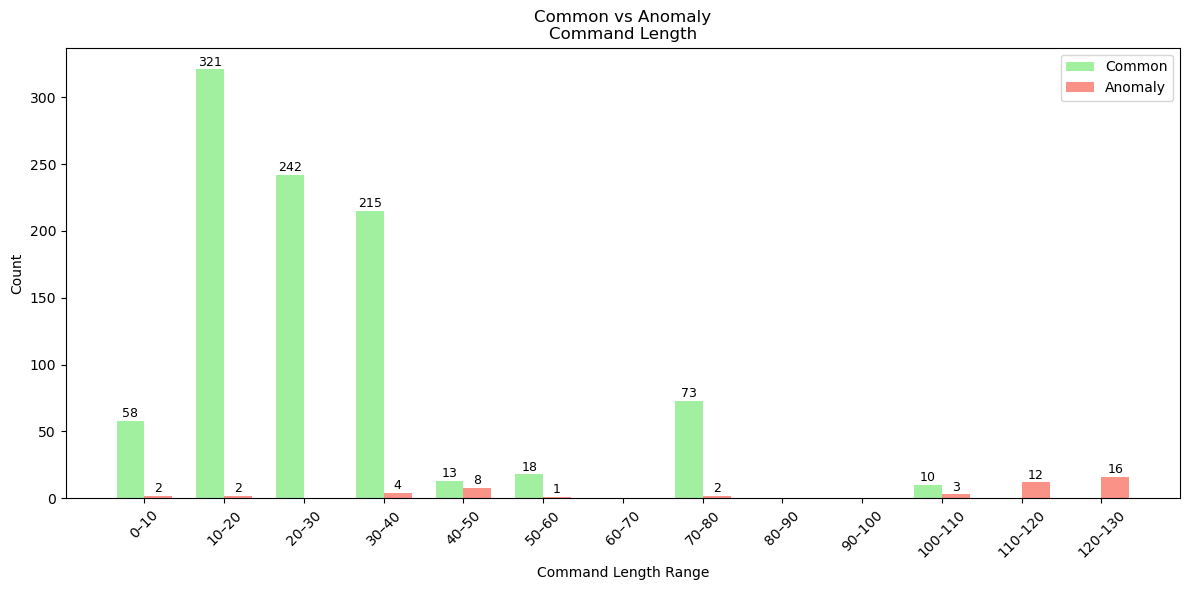

In [45]:
# Define bins
max_len = df["command_length"].max()
bins = np.arange(0, max_len + 10, 10)

# Create bin labels
bin_labels = [f"{bins[i]}–{bins[i+1]}" for i in range(len(bins)-1)]

# Assign every row to a bin
df["length_bin"] = pd.cut(
    df["command_length"],
    bins=bins,
    labels=bin_labels,
    include_lowest=True
)

# Split normal + anomaly
anomalies = df[df["is_anomaly"] == 1]
normals   = df[df["is_anomaly"] == 0]

# Count per bin
anomaly_counts = anomalies["length_bin"].value_counts().reindex(bin_labels, fill_value=0)
normal_counts  = normals["length_bin"].value_counts().reindex(bin_labels, fill_value=0)

# Bar positions
x = np.arange(len(bin_labels))
width = 0.35

# Plot
plt.figure(figsize=(12, 6))
bars_normal = plt.bar(x - width/2, normal_counts.values, width, 
                      label="Common", color="lightgreen", alpha=0.85)
bars_anomaly = plt.bar(x + width/2, anomaly_counts.values, width, 
                       label="Anomaly", color="salmon", alpha=0.85)

# Add counts above bars
for bar in bars_normal:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(int(height)), 
                 ha='center', va='bottom', fontsize=9)

for bar in bars_anomaly:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(int(height)), 
                 ha='center', va='bottom', fontsize=9)

plt.xlabel("Command Length Range")
plt.ylabel("Count")
plt.title("Common vs Anomaly\nCommand Length")
plt.xticks(x, bin_labels, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


We can see that usually longer commands --> anomalous activity

In [46]:
# Gather similar command lengths into bins

df["length_bin"] = pd.cut(
    df["command_length"],
    bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130],  # custom ranges
    labels=["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]
)

df.head()


,timestamp,user_name,parent_process,process,command,command_length,num_args,is_anomaly,length_bin
0,02-11-25 06:13:08,svc_unknown,winword.exe,msiexec.exe,"powershell -Command ""$wc = New-Object System.N...",129,7,1,12
1,02-11-25 09:50:21,oleg.kov,winword.exe,msiexec.exe,cmd.exe /c echo hello,21,4,0,2
2,02-11-25 10:18:14,svc_sql,searchui.exe,schtasks.exe,msiexec /i C:\installers\app.msi /qn,36,4,0,3
3,02-11-25 11:16:03,li.chen,onedrive.exe,net.exe,whoami,6,1,0,0
4,02-11-25 11:31:33,svc_sql,msedge.exe,msiexec.exe,Get-Service,11,1,0,1


### Command arguments counts per label

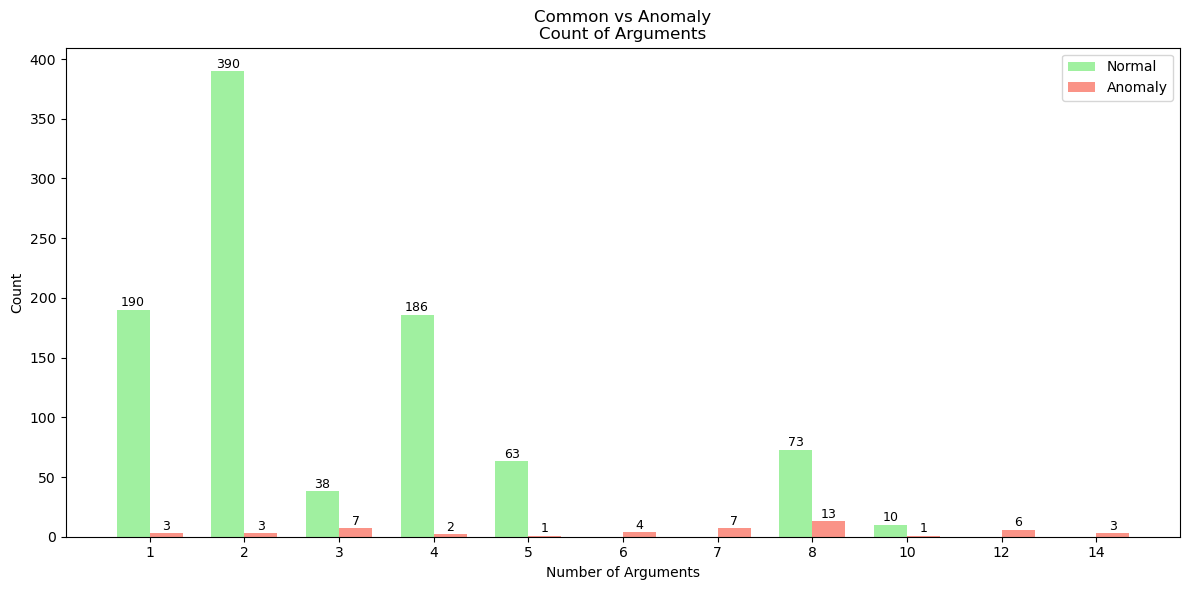

In [47]:

# Split normal + anomaly
anomalies = df[df["is_anomaly"] == 1]
normals   = df[df["is_anomaly"] == 0]

# Count occurrences of each num_args value
anomaly_counts = anomalies["num_args"].value_counts().sort_index()
normal_counts  = normals["num_args"].value_counts().sort_index()

# Combine all possible num_args values to make sure both have same x-axis
all_values = sorted(set(normal_counts.index) | set(anomaly_counts.index))
anomaly_counts = anomaly_counts.reindex(all_values, fill_value=0)
normal_counts  = normal_counts.reindex(all_values, fill_value=0)

# Bar positions
x = np.arange(len(all_values))
width = 0.35

# Plot
plt.figure(figsize=(12, 6))
bars_normal = plt.bar(x - width/2, normal_counts.values, width, 
                      label="Normal", color="lightgreen", alpha=0.85)
bars_anomaly = plt.bar(x + width/2, anomaly_counts.values, width, 
                       label="Anomaly", color="salmon", alpha=0.85)

# Add counts above bars, skip zeros
for bar in bars_normal:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.3, str(int(height)), 
                 ha='center', va='bottom', fontsize=9)

for bar in bars_anomaly:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.3, str(int(height)), 
                 ha='center', va='bottom', fontsize=9)

plt.xlabel("Number of Arguments")
plt.ylabel("Count")
plt.title("Common vs Anomaly\nCount of Arguments")
plt.xticks(x, all_values)
plt.legend()
plt.tight_layout()
plt.show()


We can see that usually more arguments --> anomalous activity,  
and yet here they are spread more equally in comparison to command_length,  
also in here we can see that the most anomalous activity blends a bit with common activity.

### Relation of command length to argument count

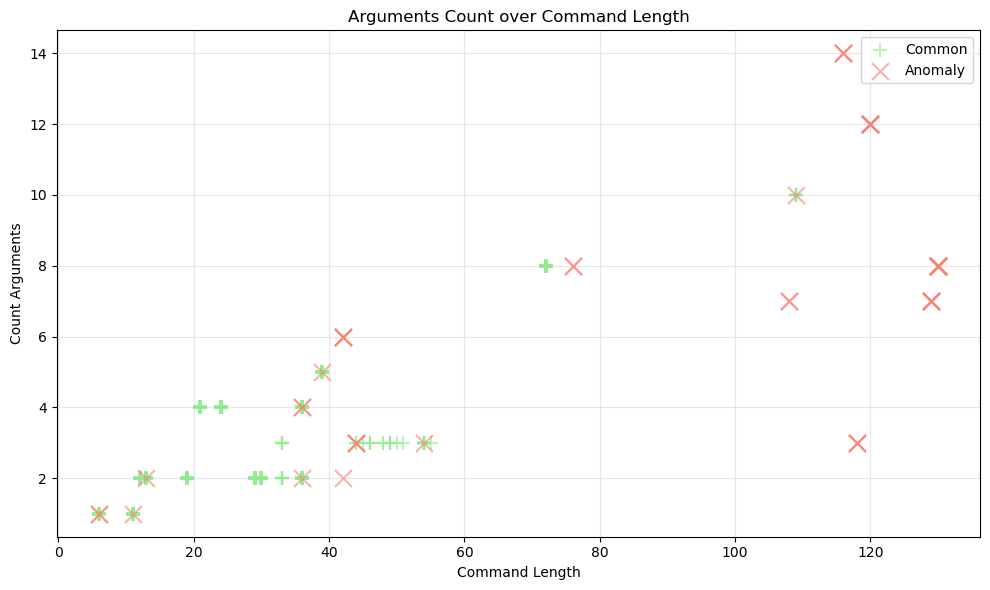

In [48]:
# Scatter plot
plt.figure(figsize=(10, 6))

# Plot normal commands
plt.scatter(
    df[df["is_anomaly"] == 0]["command_length"],
    df[df["is_anomaly"] == 0]["num_args"],
    color="lightgreen",
    alpha=0.6,
    label="Common",
    marker = "+",
    s = 100
)

# Plot anomalous commands
plt.scatter(
    df[df["is_anomaly"] == 1]["command_length"],
    df[df["is_anomaly"] == 1]["num_args"],
    color="salmon",
    alpha=0.6,
    label="Anomaly",
    marker="x",
    s = 150
)

plt.xlabel("Command Length")
plt.ylabel("Count Arguments")
plt.title("Arguments Count over Command Length")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [49]:
# Pearsonrs cororolation
corr, p_value = pearsonr(df["num_args"], df["command_length"])
print("Pearson correlation:", corr)
print("p-value:", p_value)


Pearson correlation: 0.8498086326689204
p-value: 8.220394463615208e-280


We can see by the scatterplot and by the pearson correlation that these two features have high positive correlation.  
We will get rid of num_args later to get better results for our model.

## Feature Engineering

### Parent process, process features

In [50]:
# Create mapping
parent_process_mapping = {name: idx for idx, name in enumerate(df["parent_process"].unique())}
process_mapping = {name: idx for idx, name in enumerate(df["process"].unique())}

# add process_id column with numeric process IDs
df["parent_process_id"] = df["parent_process"].map(parent_process_mapping)
df["process_id"] = df["process"].map(process_mapping)

df.head()


,timestamp,user_name,parent_process,process,command,command_length,num_args,is_anomaly,length_bin,parent_process_id,process_id
0,02-11-25 06:13:08,svc_unknown,winword.exe,msiexec.exe,"powershell -Command ""$wc = New-Object System.N...",129,7,1,12,0,0
1,02-11-25 09:50:21,oleg.kov,winword.exe,msiexec.exe,cmd.exe /c echo hello,21,4,0,2,0,0
2,02-11-25 10:18:14,svc_sql,searchui.exe,schtasks.exe,msiexec /i C:\installers\app.msi /qn,36,4,0,3,1,1
3,02-11-25 11:16:03,li.chen,onedrive.exe,net.exe,whoami,6,1,0,0,2,2
4,02-11-25 11:31:33,svc_sql,msedge.exe,msiexec.exe,Get-Service,11,1,0,1,3,0


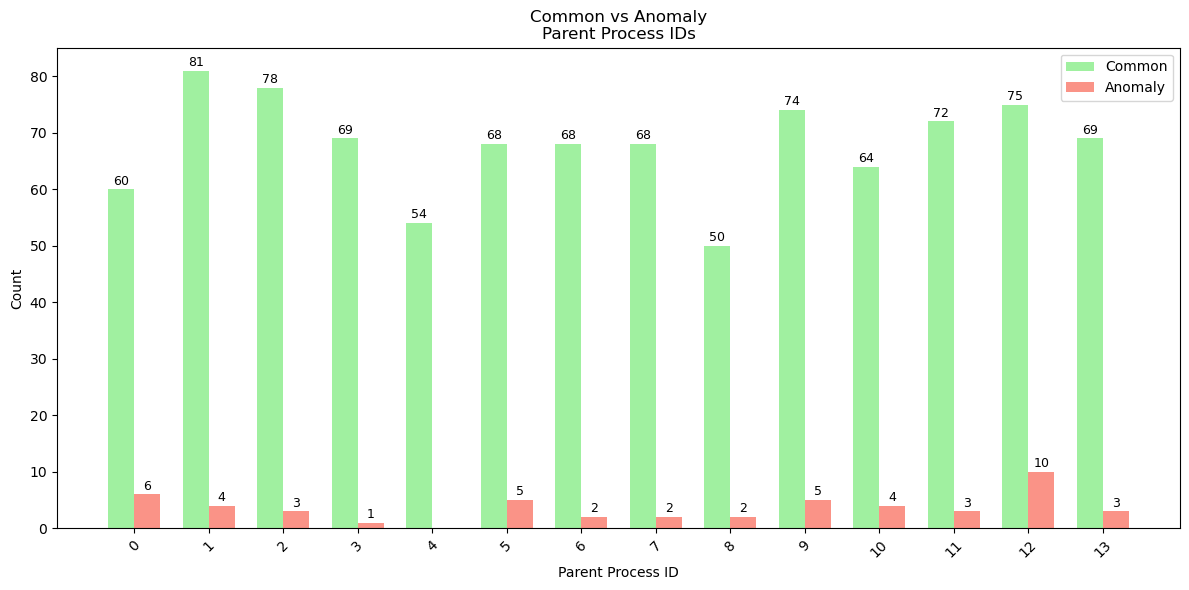

In [51]:
# Split normal and anomalous
anomalies = df[df["is_anomaly"] == 1]
normals   = df[df["is_anomaly"] == 0]

# Count occurrences of each process_id
anomaly_counts = anomalies["parent_process_id"].value_counts().sort_index()
normal_counts  = normals["parent_process_id"].value_counts().sort_index()

# Make sure both have same x-axis
all_ids = sorted(set(normal_counts.index) | set(anomaly_counts.index))
anomaly_counts = anomaly_counts.reindex(all_ids, fill_value=0)
normal_counts  = normal_counts.reindex(all_ids, fill_value=0)

# Bar positions
x = np.arange(len(all_ids))
width = 0.35

# Plot
plt.figure(figsize=(12, 6))
bars_normal = plt.bar(x - width/2, normal_counts.values, width, 
                      label="Common", color="lightgreen", alpha=0.85)
bars_anomaly = plt.bar(x + width/2, anomaly_counts.values, width, 
                       label="Anomaly", color="salmon", alpha=0.85)

# Add counts above bars, skip zeros
for bar in bars_normal:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.3, str(int(height)), 
                 ha='center', va='bottom', fontsize=9)

for bar in bars_anomaly:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.3, str(int(height)), 
                 ha='center', va='bottom', fontsize=9)

plt.xlabel("Parent Process ID")
plt.ylabel("Count")
plt.title("Common vs Anomaly\nParent Process IDs")
plt.xticks(x, all_ids, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Here we can see that anomalies occur almost equally in most parent processes with the exception of a few which are considerably anomalous

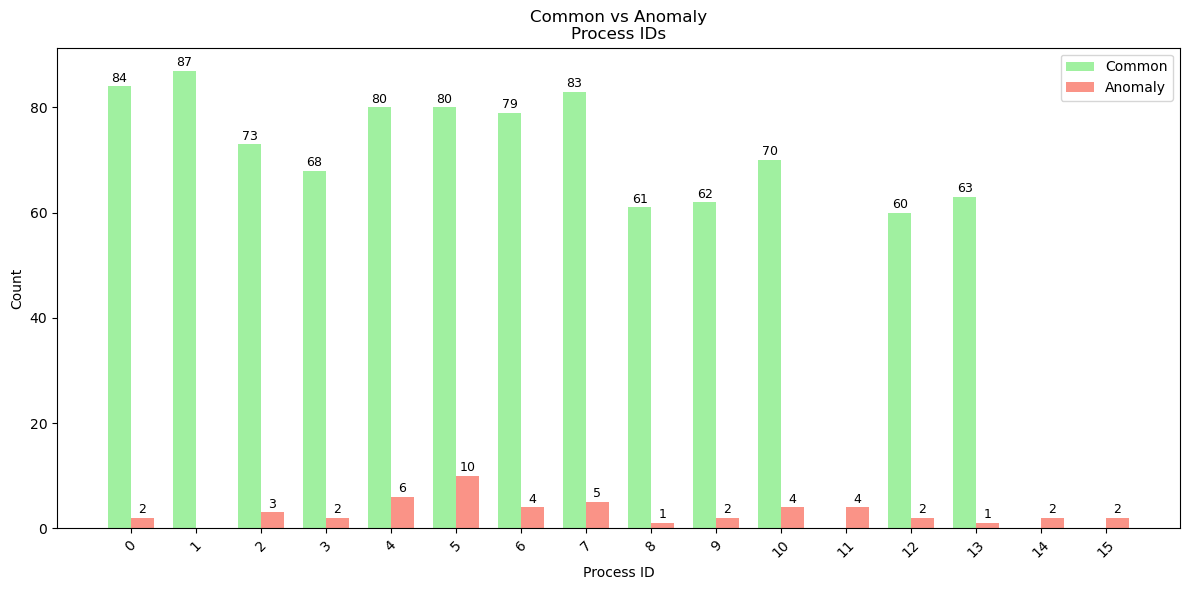

In [52]:
# Split normal and anomalous
anomalies = df[df["is_anomaly"] == 1]
normals   = df[df["is_anomaly"] == 0]

# Count occurrences of each process_id
anomaly_counts = anomalies["process_id"].value_counts().sort_index()
normal_counts  = normals["process_id"].value_counts().sort_index()

# Make sure both have same x-axis
all_ids = sorted(set(normal_counts.index) | set(anomaly_counts.index))
anomaly_counts = anomaly_counts.reindex(all_ids, fill_value=0)
normal_counts  = normal_counts.reindex(all_ids, fill_value=0)

# Bar positions
x = np.arange(len(all_ids))
width = 0.35

# Plot
plt.figure(figsize=(12, 6))
bars_normal = plt.bar(x - width/2, normal_counts.values, width, 
                      label="Common", color="lightgreen", alpha=0.85)
bars_anomaly = plt.bar(x + width/2, anomaly_counts.values, width, 
                       label="Anomaly", color="salmon", alpha=0.85)

# Add counts above bars, skip zeros
for bar in bars_normal:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.3, str(int(height)), 
                 ha='center', va='bottom', fontsize=9)

for bar in bars_anomaly:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.3, str(int(height)), 
                 ha='center', va='bottom', fontsize=9)

plt.xlabel("Process ID")
plt.ylabel("Count")
plt.title("Common vs Anomaly\nProcess IDs")
plt.xticks(x, all_ids, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Here we can also see that anomalies occur almost equally in most processes with the exception of a few processes which are considerably anomalous

In [53]:
#Checking if there's a correlation between "Process" and "Parent_Process" using Cramers V.

table = pd.crosstab(df["process"], df["parent_process"])
chi2 = chi2_contingency(table)[0]
n = table.sum().sum()
phi2 = chi2/n
r, k = table.shape
print(np.sqrt(phi2 / min(r-1, k-1)))


0.12538925831523798


We assumed "parent_process" and "process" features are correlated,  
we checked but the correlation is 0.125 which is weak.  

### timestamp feature

In [54]:
# Parse timestamp column into datetime
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%d-%m-%y %H:%M:%S")

# Day of week (Monday=0 ... Sunday=6)
# But you want Saturday=0 ... Friday=6
df["day_of_week"] = (df["timestamp"].dt.dayofweek + 2) % 7

# Extract hour (0–23)
df["hour"] = df["timestamp"].dt.hour

# Work hours = 09:00 to 19:59
df["is_work_hours"] = df["hour"].between(9, 19).astype(int)

df.head()

,timestamp,user_name,parent_process,process,command,command_length,num_args,is_anomaly,length_bin,parent_process_id,process_id,day_of_week,hour,is_work_hours
0,2025-11-02 06:13:08,svc_unknown,winword.exe,msiexec.exe,"powershell -Command ""$wc = New-Object System.N...",129,7,1,12,0,0,1,6,0
1,2025-11-02 09:50:21,oleg.kov,winword.exe,msiexec.exe,cmd.exe /c echo hello,21,4,0,2,0,0,1,9,1
2,2025-11-02 10:18:14,svc_sql,searchui.exe,schtasks.exe,msiexec /i C:\installers\app.msi /qn,36,4,0,3,1,1,1,10,1
3,2025-11-02 11:16:03,li.chen,onedrive.exe,net.exe,whoami,6,1,0,0,2,2,1,11,1
4,2025-11-02 11:31:33,svc_sql,msedge.exe,msiexec.exe,Get-Service,11,1,0,1,3,0,1,11,1


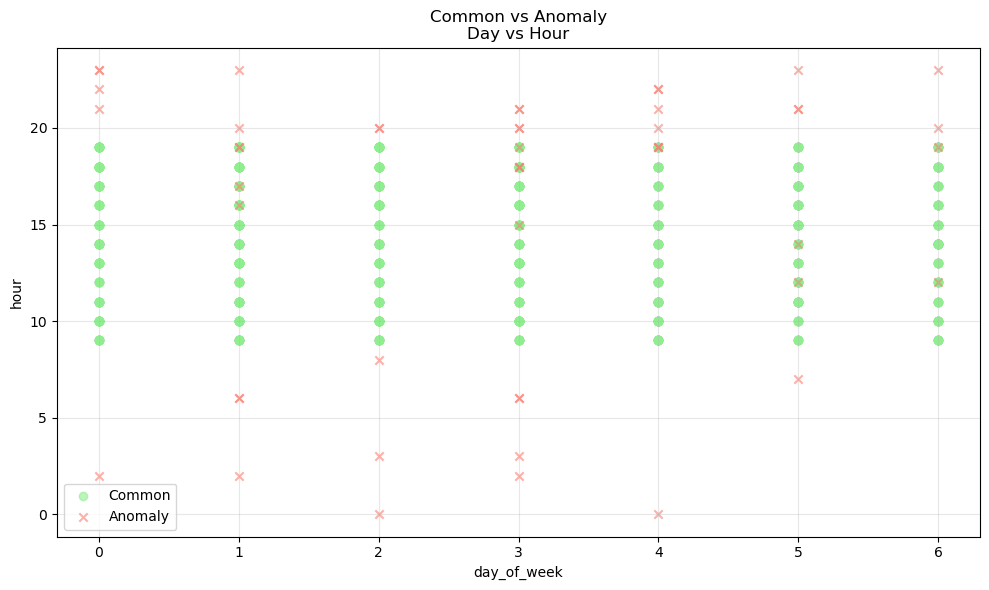

In [55]:
#Scatterplot of Hours vs Days

# Scatter plot
plt.figure(figsize=(10, 6))

# Plot common time
plt.scatter(
    df[df["is_anomaly"] == 0]["day_of_week"],
    df[df["is_anomaly"] == 0]["hour"],
    color="lightgreen",
    alpha=0.6,
    label="Common",
    #s = 100
)

# Plot anomalous time
plt.scatter(
    df[df["is_anomaly"] == 1]["day_of_week"],
    df[df["is_anomaly"] == 1]["hour"],
    color="salmon",
    alpha=0.6,
    label="Anomaly",
    marker = "x"
    #s = 150
)

plt.xlabel("day_of_week")
plt.ylabel("hour")
plt.title("Common vs Anomaly\nDay vs Hour")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Here we can easily see that most anomalous activity takes place outside work hours throughout the week

### command length feature normalization

In [56]:

# Compute z-scores
df["command_length_zscore"] = zscore(df["command_length"])

df.head()

,timestamp,user_name,parent_process,process,command,command_length,num_args,is_anomaly,length_bin,parent_process_id,process_id,day_of_week,hour,is_work_hours,command_length_zscore
0,2025-11-02 06:13:08,svc_unknown,winword.exe,msiexec.exe,"powershell -Command ""$wc = New-Object System.N...",129,7,1,12,0,0,1,6,0,3.904293
1,2025-11-02 09:50:21,oleg.kov,winword.exe,msiexec.exe,cmd.exe /c echo hello,21,4,0,2,0,0,1,9,1,-0.413156
2,2025-11-02 10:18:14,svc_sql,searchui.exe,schtasks.exe,msiexec /i C:\installers\app.msi /qn,36,4,0,3,1,1,1,10,1,0.186490
3,2025-11-02 11:16:03,li.chen,onedrive.exe,net.exe,whoami,6,1,0,0,2,2,1,11,1,-1.012802
4,2025-11-02 11:31:33,svc_sql,msedge.exe,msiexec.exe,Get-Service,11,1,0,1,3,0,1,11,1,-0.812920


### user name feature

In [57]:
# Now we will map usernames

# Create mapping
user_mapping = {name: idx for idx, name in enumerate(df["user_name"].unique())}

# add process_id column with numeric process IDs
df["user_id"] = df["user_name"].map(user_mapping)

df.head()

,timestamp,user_name,parent_process,process,command,command_length,num_args,is_anomaly,length_bin,parent_process_id,process_id,day_of_week,hour,is_work_hours,command_length_zscore,user_id
0,2025-11-02 06:13:08,svc_unknown,winword.exe,msiexec.exe,"powershell -Command ""$wc = New-Object System.N...",129,7,1,12,0,0,1,6,0,3.904293,0
1,2025-11-02 09:50:21,oleg.kov,winword.exe,msiexec.exe,cmd.exe /c echo hello,21,4,0,2,0,0,1,9,1,-0.413156,1
2,2025-11-02 10:18:14,svc_sql,searchui.exe,schtasks.exe,msiexec /i C:\installers\app.msi /qn,36,4,0,3,1,1,1,10,1,0.186490,2
3,2025-11-02 11:16:03,li.chen,onedrive.exe,net.exe,whoami,6,1,0,0,2,2,1,11,1,-1.012802,3
4,2025-11-02 11:31:33,svc_sql,msedge.exe,msiexec.exe,Get-Service,11,1,0,1,3,0,1,11,1,-0.812920,2


### Drop un-needed features

In [58]:
#Now we will get rid of some redundant features

df.drop(columns=["timestamp", "user_name", "parent_process", "process", "command", "command_length", "num_args"], inplace = True)
df.head()

,is_anomaly,length_bin,parent_process_id,process_id,day_of_week,hour,is_work_hours,command_length_zscore,user_id
0,1,12,0,0,1,6,0,3.904293,0
1,0,2,0,0,1,9,1,-0.413156,1
2,0,3,1,1,1,10,1,0.186490,2
3,0,0,2,2,1,11,1,-1.012802,3
4,0,1,3,0,1,11,1,-0.812920,2


## EDA Summary
in conclusion of the EDA we did, we've noticed some patterns:
1. Longer command or arguments usually indicate anomalies
2. Anomalies often occur before or after work hours throughout the week
3. We have dropped some redundant and highly correlated features due to the insights of the EDA

# Anomaly Detection Model

Splitting the dataset into train, validation and test

In [59]:

# Separate features and target
X = df.drop("is_anomaly", axis=1)  # all features
y = df["is_anomaly"]               # target label

# First, split into train + temp (temp will be split into val and test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,      # 30% will go to validation + test
    stratify=y,         # preserves label proportions
    random_state=42
)

# Split temp into validation and test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,      # half of temp → test, half → validation
    stratify=y_temp,    # preserves label proportions in val/test
    random_state=42
)

# Check sizes
print("Train size:", X_train.shape[0])
print("Validation size:", X_val.shape[0])
print("Test size:", X_test.shape[0])


Train size: 700
Validation size: 150
Test size: 150


In [60]:
# Hyperparameters to try
n_estimators_list = [50, 100, 200]
contamination_list = [0.03, 0.04, 0.05, 0.06]

best_score = 0
best_model = None
best_est = 0
best_cont = 0

for n_estimators in n_estimators_list:
    for contamination in contamination_list:
        # Initialize the model
        iso_forest = IsolationForest(
            n_estimators=n_estimators,
            contamination=contamination,
            random_state=42
        )

        # Train on training set
        iso_forest.fit(X_train)


        # Predict on validation set
        y_pred_val = iso_forest.predict(X_val)
        y_pred_val = np.where(y_pred_val == 1, 0, 1)  # map: 1→0 normal, -1→1 anomaly

        # Evaluate performance (using F1 score for imbalanced data)
        from sklearn.metrics import f1_score
        f1 = f1_score(y_val, y_pred_val)

        print(f"n_estimators={n_estimators}, contamination={contamination}, F1={f1:.4f}")

        # Keep best model
        if f1 > best_score:
            best_score = f1
            best_model = iso_forest
            best_est = n_estimators
            best_cont = contamination

print(f"\nBest model chosen with F1 = {best_score}\nBest hyperparameters:\nEstimator = {best_est}\nContamination = {best_cont}")

n_estimators=50, contamination=0.03, F1=0.8571
n_estimators=50, contamination=0.04, F1=0.9333
n_estimators=50, contamination=0.05, F1=0.8000
n_estimators=50, contamination=0.06, F1=0.7619
n_estimators=100, contamination=0.03, F1=0.8571
n_estimators=100, contamination=0.04, F1=0.9333
n_estimators=100, contamination=0.05, F1=0.8421
n_estimators=100, contamination=0.06, F1=0.7273
n_estimators=200, contamination=0.03, F1=0.9333
n_estimators=200, contamination=0.04, F1=0.9333
n_estimators=200, contamination=0.05, F1=0.8421
n_estimators=200, contamination=0.06, F1=0.7273

Best model chosen with F1 = 0.9333333333333333
Best hyperparameters:
Estimator = 50
Contamination = 0.04



Test set performance:
Accuracy: 0.98
Precision: 1.0
Recall: 0.5714285714285714
F1-score: 0.7272727272727273


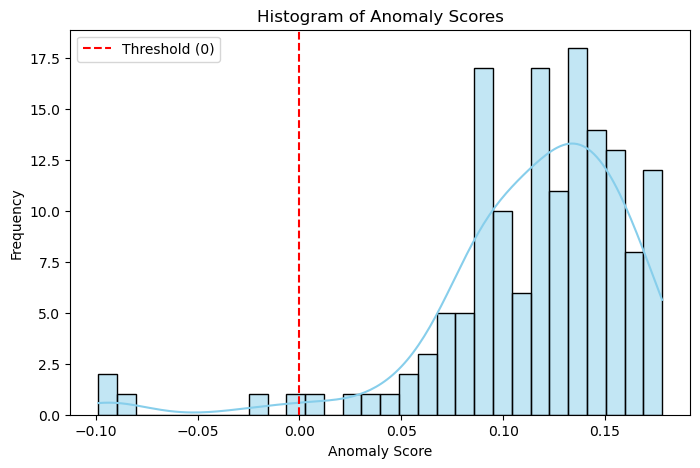

In [61]:
# Final evaluation on test set
y_pred_test = best_model.predict(X_test)
y_pred_test = np.where(y_pred_test == 1, 0, 1)

print("\nTest set performance:")

print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Precision:", precision_score(y_test, y_pred_test))
print("Recall:", recall_score(y_test, y_pred_test))
print("F1-score:", f1_score(y_test, y_pred_test))

# Anomaly scores: negative = more anomalous
scores = best_model.decision_function(X_test)  # higher = more normal, lower = more anomalous


# Example: histogram of anomaly scores
plt.figure(figsize=(8,5))
sns.histplot(scores, bins=30, kde=True, color='skyblue')
plt.title("Histogram of Anomaly Scores")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.axvline(x=0, color='red', linestyle='--', label='Threshold (0)')
plt.legend()
plt.show()


Model Evaluation Summary:

The Isolation Forest achieved 98% accuracy and perfect precision (1.0), meaning all detected anomalies were correct. However, recall was 0.57, so the model missed some anomalies, resulting in an F1-score of 0.73.

The histogram shows most points clustered near zero, with a few lower-score points flagged as anomalies. The threshold line clearly separates normal from anomalous behavior.

# Visualize Anomalies 2D

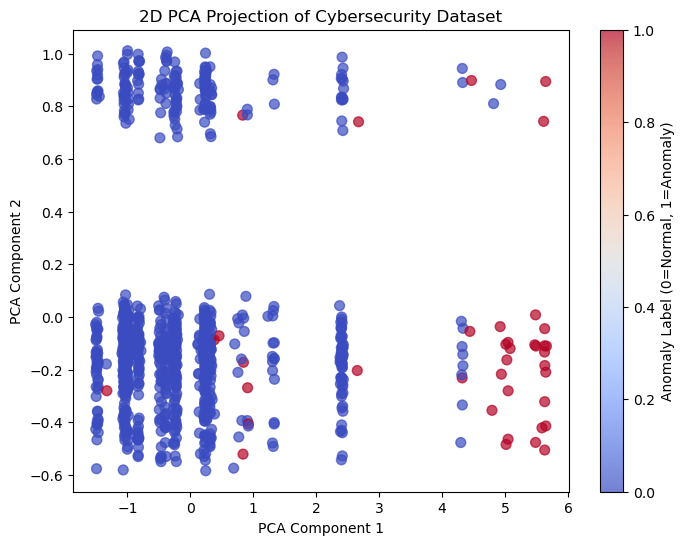

In [62]:
# Example feature lists
numeric_features = ['length_bin', 'command_length_zscore']  # replace with your numeric columns
categorical_features = ['parent_process_id', 'process_id', 'day_of_week', 'hour', 'is_work_hours', 'user_id']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(sparse_output=False), categorical_features)
    ]
)

preprocessor.fit(df)

# --- 1. Preprocess dataset for PCA only ---
X_processed = preprocessor.transform(df)

# --- 2. Fit PCA to reduced 2D space ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

# --- 3. Predict using the trained IsolationForest model (NO PREPROCESSING!) ---
X_raw = df[best_model.feature_names_in_]
y_full_pred = best_model.predict(X_raw)

# Convert IsolationForest output to 0/1
y_full_pred = np.where(y_full_pred == 1, 0, 1)

# --- 4. Plot the PCA projection with anomaly colors ---
plt.figure(figsize=(8, 6))
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=y_full_pred,
    cmap='coolwarm',
    s=50,
    alpha=0.7
)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("2D PCA Projection of Cybersecurity Dataset")
plt.colorbar(label='Anomaly Label (0=Normal, 1=Anomaly)')
plt.show()



This PCA plot shows that the dataset forms several distinct clusters in 2-dimensional space, meaning the underlying features create clear structural groupings.  
The red anomaly points tend to appear on the right edges or in smaller, separate clusters, indicating that the Isolation Forest mainly flags samples that deviate from the dominant, dense normal regions.  
Overall, the model appears to separate unusual behavior from the main activity patterns effectively.

# Summary

The model was able to detect a meaningful portion of the injected anomalies, achieving a recall of 0.57, which means it successfully identified a bit more than half of all true malicious events.  
This indicates that Isolation Forest learned the dominant structure of normal behavior and could flag many deviations, but some anomalies were subtle enough to blend into normal patterns and were missed.  
Overall, the model shows solid detection capability but also highlights the need for richer features or additional modeling techniques to capture the more stealthy anomalies.